In [2]:
import os
import numpy as np
import pandas as pd

from pyopenms import MSExperiment, MzMLFile
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle

from mzml_pdiff import load_from_csv
from mzml_pdiff import save_to_csv
from mzml_pdiff import process_file

In [3]:
df_speclib = pd.read_csv("speclib_incl_34_36.tsv", sep="\t")

In [4]:
unique_peptidoform_df = df_speclib.drop_duplicates(
    ["Tr_recalibrated", "FullUniModPeptideName"]
)

unique_peptidoform_df[
    unique_peptidoform_df["FullUniModPeptideName"].str.contains("UniMod:21")
]

,FileName,PrecursorMz,ProductMz,Tr_recalibrated,IonMobility,transition_name,LibraryIntensity,transition_group_id,decoy,PeptideSequence,...,PrecursorCharge,PeptideGroupLabel,UniprotID,NTerm,CTerm,FragmentType,FragmentCharge,FragmentSeriesNumber,FragmentLossType,ExcludeFromAssay
165,C:\DIA-NN\1.8.2 beta 39\asms\library\ecoli_oxm...,1195.5824,301.18704,25.639141,1.351357,AAAAAKGMPLY(UniMod:21)EHIAELNGTPGK2_121_1_0_20,1.0,AAAAAKGMPLY(UniMod:21)EHIAELNGTPGK2,0,AAAAAKGMPLYEHIAELNGTPGK,...,2,AAAAAKGMPLY(UniMod:21)EHIAELNGTPGK,P0A6P9,0,0,y,1,3,noloss,False
201,C:\DIA-NN\1.8.2 beta 39\asms\library\ecoli_oxm...,1195.5824,301.18704,39.575958,1.365929,AAAAAKGMPLYEHIAELNGT(UniMod:21)PGK2_121_1_0_20,1.0,AAAAAKGMPLYEHIAELNGT(UniMod:21)PGK2,0,AAAAAKGMPLYEHIAELNGTPGK,...,2,AAAAAKGMPLYEHIAELNGT(UniMod:21)PGK,P0A6P9,0,0,y,1,3,noloss,False
381,C:\DIA-NN\1.8.2 beta 39\asms\library\ecoli_oxm...,1202.5902,301.18704,25.639141,1.351357,AAAAAK(UniMod:34)GMPLY(UniMod:21)EHIAELNGTPGK2...,1.0,AAAAAK(UniMod:34)GMPLY(UniMod:21)EHIAELNGTPGK2,0,AAAAAKGMPLYEHIAELNGTPGK,...,2,AAAAAK(UniMod:34)GMPLY(UniMod:21)EHIAELNGTPGK,P0A6P9,0,0,y,1,3,noloss,False
417,C:\DIA-NN\1.8.2 beta 39\asms\library\ecoli_oxm...,1209.5980,301.18704,25.639141,1.351357,AAAAAK(UniMod:36)GMPLY(UniMod:21)EHIAELNGTPGK2...,1.0,AAAAAK(UniMod:36)GMPLY(UniMod:21)EHIAELNGTPGK2,0,AAAAAKGMPLYEHIAELNGTPGK,...,2,AAAAAK(UniMod:36)GMPLY(UniMod:21)EHIAELNGTPGK,P0A6P9,0,0,y,1,3,noloss,False
453,C:\DIA-NN\1.8.2 beta 39\asms\library\ecoli_oxm...,1202.5902,301.18704,39.575958,1.365929,AAAAAK(UniMod:34)GMPLYEHIAELNGT(UniMod:21)PGK2...,1.0,AAAAAK(UniMod:34)GMPLYEHIAELNGT(UniMod:21)PGK2,0,AAAAAKGMPLYEHIAELNGTPGK,...,2,AAAAAK(UniMod:34)GMPLYEHIAELNGT(UniMod:21)PGK,P0A6P9,0,0,y,1,3,noloss,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260102264,C:\DIA-NN\1.8.2 beta 39\asms\library\ecoli_oxm...,1561.1852,419.24014,112.959750,1.467661,YYYTFDNSLLFTESIQNT(UniMod:21)T(UniMod:21)QIFPR...,1.0,YYYTFDNSLLFTESIQNT(UniMod:21)T(UniMod:21)QIFPR2,0,YYYTFDNSLLFTESIQNTTQIFPR,...,2,YYYTFDNSLLFTESIQNT(UniMod:21)T(UniMod:21)QIFPR,P77598,0,1,y,1,3,noloss,False
260102300,C:\DIA-NN\1.8.2 beta 39\asms\library\ecoli_oxm...,1528.2098,433.25577,126.640900,1.467387,YYYTFDNSLLFTESIQNT(UniMod:21)TQIFPR(UniMod:34)...,1.0,YYYTFDNSLLFTESIQNT(UniMod:21)TQIFPR(UniMod:34)2,0,YYYTFDNSLLFTESIQNTTQIFPR,...,2,YYYTFDNSLLFTESIQNT(UniMod:21)TQIFPR(UniMod:34),P77598,0,1,y,1,3,noloss,False
260102336,C:\DIA-NN\1.8.2 beta 39\asms\library\ecoli_oxm...,1535.2177,447.27142,126.640900,1.467387,YYYTFDNSLLFTESIQNT(UniMod:21)TQIFPR(UniMod:36)...,1.0,YYYTFDNSLLFTESIQNT(UniMod:21)TQIFPR(UniMod:36)2,0,YYYTFDNSLLFTESIQNTTQIFPR,...,2,YYYTFDNSLLFTESIQNT(UniMod:21)TQIFPR(UniMod:36),P77598,0,1,y,1,3,noloss,False
260102372,C:\DIA-NN\1.8.2 beta 39\asms\library\ecoli_oxm...,1528.2098,433.25577,115.909250,1.465062,YYYTFDNSLLFTESIQNTT(UniMod:21)QIFPR(UniMod:34)...,1.0,YYYTFDNSLLFTESIQNTT(UniMod:21)QIFPR(UniMod:34)2,0,YYYTFDNSLLFTESIQNTTQIFPR,...,2,YYYTFDNSLLFTESIQNTT(UniMod:21)QIFPR(UniMod:34),P77598,0,1,y,1,3,noloss,False


In [7]:
mod_sub_df = unique_peptidoform_df[
    unique_peptidoform_df["PeptideSequence"] == "YYYTFDNSLLFTESIQNTTQIFPR"
]

unmod_sub_df = unique_peptidoform_df[
    unique_peptidoform_df["FullUniModPeptideName"] == "YYYTFDNSLLFTESIQNTTQIFPR"
]

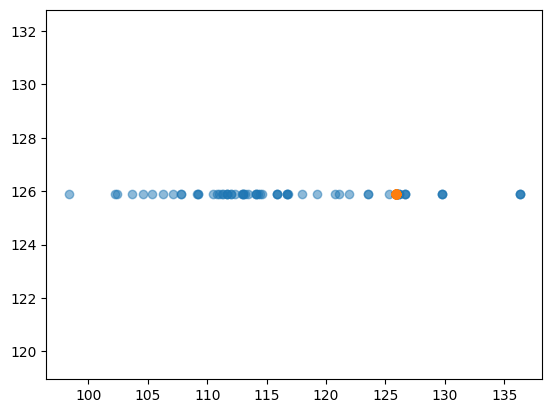

In [8]:
plt.scatter(
    mod_sub_df["Tr_recalibrated"].values,
    list(unmod_sub_df["Tr_recalibrated"].values) * len(mod_sub_df.index),
    alpha=0.5,
)
plt.scatter(
    list(unmod_sub_df["Tr_recalibrated"].values) * len(mod_sub_df.index),
    list(unmod_sub_df["Tr_recalibrated"].values) * len(mod_sub_df.index),
    alpha=0.5,
)

In [9]:
mod_sub_df[["Tr_recalibrated", "FullUniModPeptideName"]].sort_values("Tr_recalibrated")

,Tr_recalibrated,FullUniModPeptideName
260101364,98.351913,YYY(UniMod:21)TFDNSLLFTESIQNTT(UniMod:21)QIFPR
260101616,102.281010,YYYT(UniMod:21)FDNSLLFTESIQNTT(UniMod:21)QIFPR
260101076,102.440190,YY(UniMod:21)YTFDNSLLFTESIQNTT(UniMod:21)QIFPR
260100752,103.651290,Y(UniMod:21)YYTFDNSLLFTESIQNTT(UniMod:21)QIFPR
260100860,104.634000,YY(UniMod:21)Y(UniMod:21)TFDNSLLFTESIQNTTQIFPR
...,...,...
260102048,129.795100,YYYTFDNSLLFT(UniMod:21)ESIQNTTQIFPR(UniMod:34)
260102084,129.795100,YYYTFDNSLLFT(UniMod:21)ESIQNTTQIFPR(UniMod:36)
260100248,136.293620,YYYTFDNS(UniMod:21)LLFTESIQNTTQIFPR
260101868,136.293620,YYYTFDNS(UniMod:21)LLFTESIQNTTQIFPR(UniMod:34)
